In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from numpy import inf
from scipy.stats import linregress
from scipy.stats import pearsonr
import itertools
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Liberation Serif']
plt.rcParams['font.sans-serif'] = ['Liberation Sans']
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import os

In [3]:
FIG_WIDTH = 20
FIG_HEIGHT = 6
LABEL_SIZE = 30
SCATTER_PLOT_X_LABEL = 'number of data points'
COLORS = {
    'NCC-LR': '#117733',
    'NCC-HR': '#117733',
    'MPI-LR': '#882255',
    'MPI-HR': '#882255',
    'MOHC-LR': '#332288',
    'MOHC-HR': '#332288',
    'IPSL': '#88CCEE',
    'JAP': '#CC6677',
    'CMCC': '#999933',
    'EC-EARTH': '#44AA99',
    'ERA5': 'black',
}

In [5]:
class FileInformation:
    def __init__(self, file_name):
        self.file_name = file_name
        loaded_data = np.load(file_name)
        self.res = loaded_data['x']
        low = loaded_data['low']
        self.low = np.nan_to_num(np.log(low/(100-low)), nan=0)
        high = loaded_data['high']
        self.high = np.nan_to_num(np.log(high/(100-high)), nan=0)
        components = file_name.split('/')[-1].split('.')[0].split('_')
        model_category = components.pop(1)
        self.model_category = model_category
        model_name = components.pop(1)
        self.model_name = model_name
        self.color = COLORS[model_name]
        marker = 'o'
        size = 250
        if 'LR' in model_name:
            marker = 'X'
            size = 350
        self.model_label = model_name
        self.arguments = {'color': self.color, 'marker': marker, 's':size}

In [6]:
def create_model_file_list(height):
  list_of_models = []
  root = f'/content/drive/MyDrive/Paper Spatial Resolution/trends/'
  for root, dirs, files in os.walk(root):
      for filename in files:
        if str(height) in filename:
            file_path = os.path.join(root, filename)
            my_file = FileInformation(file_path)
            list_of_models.append(my_file)
  return list_of_models

In [7]:
def calculate_slopes_for_permutation_test(x_vals, y_vals, num_permutations=100000):
  log_x = np.log10(x_vals)
  y_mean = np.mean(y_vals)
  x_mean = np.mean(log_x)
  x_squared_sum = np.sum((log_x - x_mean)**2)
  slope_original = np.sum((log_x - x_mean) * (y_vals - y_mean)) / x_squared_sum
  slopes = []
  for i in range(num_permutations):
    v = np.random.permutation(y_vals)
    slope = np.sum((log_x - x_mean) * (v - y_mean)) / x_squared_sum
    slopes.append(slope)
  slopes = np.array(slopes)
  return slope_original, slopes

In [8]:
def get_permutation_test_results(list_of_models, val_name):
  resolutions = []
  values = []
  for model_information in list_of_models:
      res = model_information.res
      resolutions.append(res)
      val =  getattr(model_information, val_name)
      values.append(val)
  slope_original, slopes = calculate_slopes_for_permutation_test(resolutions,
                                                                 values)
  conf_lower = np.percentile(slopes, 2.5)
  conf_upper = np.percentile(slopes, 97.5)
  p_value = np.sum(slopes > slope_original) / len(slopes)
  var_v = np.var(values)
  print(f"{val_name}: MaxVal MinVal Var St.Dev. Slope 2.5% 97.5% P-value")
  print(f"{val_name} & {np.max(v):.3f} & {np.min(v):.3f} & {var_v:.3f}"
        f" & {np.sqrt(var_v):.3f} & & {slope_original:.3f}"
        f" & {conf_lower:.4f} & {conf_upper:.4f}"
        f" & {p_value:.4f} \\\\")
  return {"confidence_interval": [conf_lower, conf_upper], "p_value": p_value}

In [9]:
def linear(x, a, b):
    return a * x + b

def plot_regression_line(x, v, ax, name, permu_results=None):
    log_x = np.log10(x)
    slope, intercept, r, p, se = linregress(log_x, np.array(v))
    print(f"{name}: Intercept Slope St.Dev. R-squared  P-value")
    print(f"{name} & {intercept:.3f} & {slope:.3f} & {se:.3f} & {r ** 2 * 100:.3f} & {p:.4f} \\\\")
    x_fit = np.logspace(log_x.min()-0.1, log_x.max()+0.1, 100)
    log_x_fit = np.log10(x_fit)
    y_fit = linear(log_x_fit, slope, intercept)
    ax.plot(x_fit, y_fit, color='grey', linewidth=1,
            label='Regression Line', zorder=0)
    if permu_results is not None:
      confidence_interval = permu_results["confidence_interval"]
      slope_low = confidence_interval[0]
      y_low = linear(log_x_fit, slope_low, intercept)
      slope_up = confidence_interval[1]
      y_up = linear(log_x_fit, slope_up, intercept)
      ax.fill_between(x_fit, y_low, y_up,
                    color='grey', alpha=0.3, label="Standard Errors")
    else:
      std_errors = np.full_like(x_fit, se)
      ax.fill_between(x_fit, y_fit - std_errors, y_fit + std_errors,
                    color='grey', alpha=0.3, label="Standard Errors")

In [11]:
def plot_trend_with_spatial_resolution(ax, val_name, y_label,
                                       letter=None, permu_info=None):
  ax.set_ylabel(y_label, fontsize=LABEL_SIZE)
  ax.set_xlabel(SCATTER_PLOT_X_LABEL, fontsize=LABEL_SIZE)
  ax.set_xscale('log')
  ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE - 2)
  ax.tick_params(axis='both', which='minor', labelsize=LABEL_SIZE - 4)
  resolutions = []
  values = []
  distances = {}
  for model_information in list_of_models:
    res = model_information.res
    resolutions.append(res)
    val =  getattr(model_information, val_name)
    values.append(val)
    ax.scatter(res, val,label=model_information.model_label,
            zorder=2, **model_information.arguments)
    distances[model_information.model_label] = val
  if permu_info is not None:
    plot_regression_line(resolutions, values, ax, y_label, permu_info)
  else:
    plot_regression_line(resolutions, values, ax, y_label)
  if letter is not None:
    ax.text(
            x=0.03,
            y=0.97,
            s=str(letter),
            transform=ax.transAxes,
            fontsize=LABEL_SIZE+6,
            fontweight='bold',
            va='top',
            ha='left'
        )

log odds: Intercept Slope St.Dev. R-squared  P-value
log odds & -1.355 & 0.059 & 0.371 & 0.282 & 0.8769 \\
: Intercept Slope St.Dev. R-squared  P-value
 & -6.050 & -0.604 & 0.470 & 15.512 & 0.2307 \\


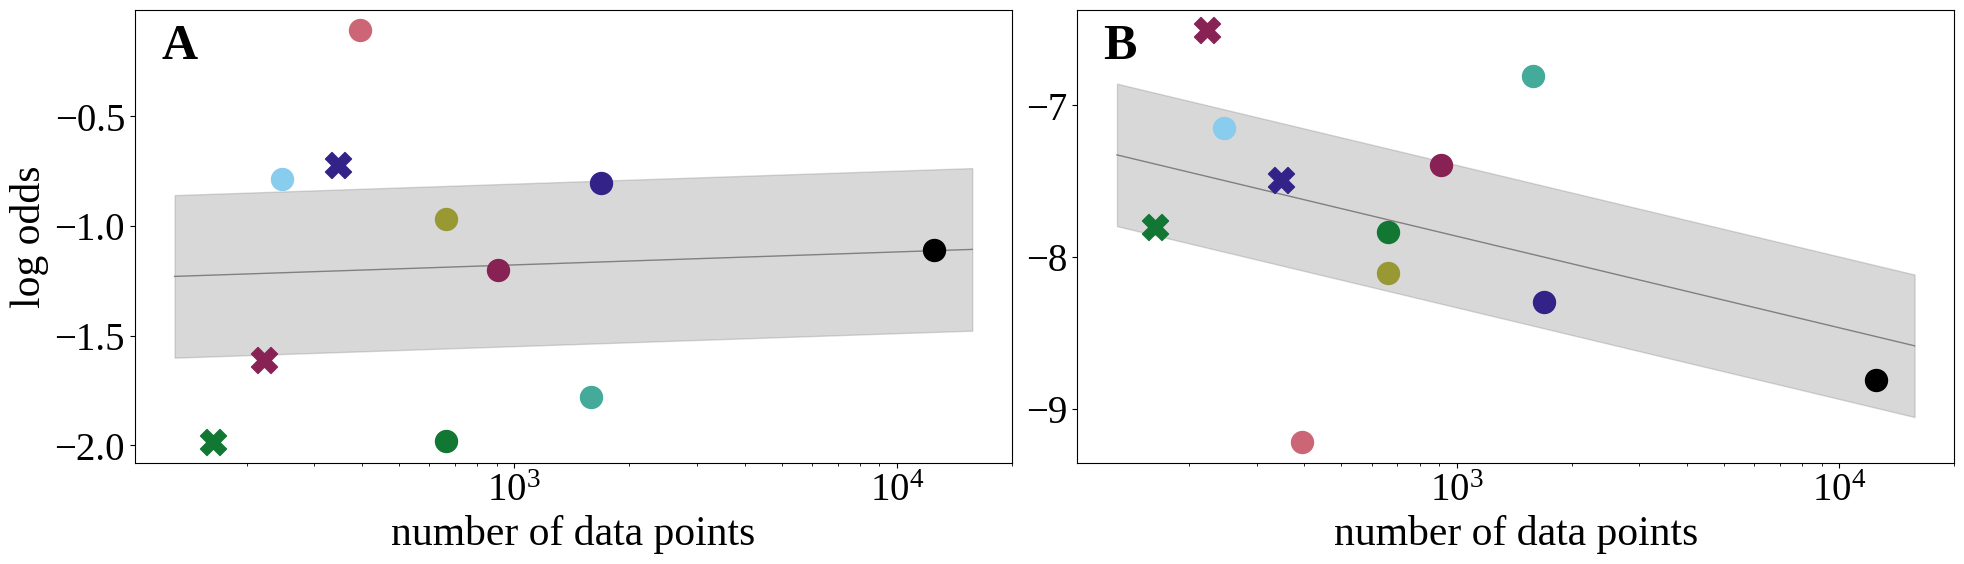

In [18]:
list_of_models = create_model_file_list(126)
fig, axes = plt.subplots(1, 2, figsize=(FIG_WIDTH, FIG_HEIGHT))

ax = axes[0]
y_label = 'log odds'
#permu_results_low = get_permutation_test_results(list_of_models, "low")
plot_trend_with_spatial_resolution(ax, 'low', y_label, 'A')#permu_results_low

ax = axes[1]
y_label = ''
#permu_results_high = get_permutation_test_results(list_of_models, "high")
plot_trend_with_spatial_resolution(ax, 'high', y_label, 'B')#permu_results_high

fig.tight_layout(pad=2.0, h_pad=1.0, w_pad=1.0)
legend_name = f'tails_europeland_126m_2005-2015_with_regression'
fig.savefig(f'{legend_name}.pdf', bbox_inches="tight")

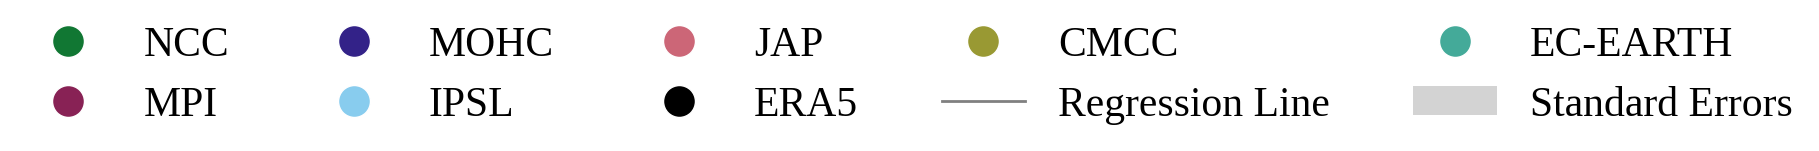

In [13]:
fig_legend, ax_legend = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT / 4))
ax_legend.axis('off')
marker_size = 23

LABELS = {
    'NCC':  Line2D([], [], color="white", marker='o', markersize=marker_size, markerfacecolor=COLORS['NCC-LR'], label='NCC'),
    'MPI':  Line2D([], [], color="white", marker='o', markersize=marker_size, markerfacecolor=COLORS['MPI-LR'],  label='MPI'),
    'MOHC':  Line2D([], [], color="white", marker='o', markersize=marker_size, markerfacecolor=COLORS['MOHC-LR'], label='MOHC'),
    'IPSL': Line2D([], [], color="white", marker='o', markersize=marker_size, markerfacecolor=COLORS['IPSL'], label='IPSL'),
    'JAP':  Line2D([], [], color="white", marker='o', markersize=marker_size, markerfacecolor=COLORS['JAP'], label='JAP'),
    'ERA5': Line2D([], [], color="white", marker='o', markersize=marker_size, markerfacecolor=COLORS['ERA5'], label='ERA5'),
    'CMCC':  Line2D([], [], color="white", marker='o', markersize=marker_size, markerfacecolor=COLORS['CMCC'], label='CMCC'),
    'Regression Line': Line2D([0], [0], color='grey', lw=2, label='Regression Line'),
    'EC-EARTH':  Line2D([], [], color="white", marker='o', markersize=marker_size, markerfacecolor=COLORS['EC-EARTH'], label='EC-EARTH'),
    'Standard Errors': Patch(facecolor='lightgrey', edgecolor='none', label='Standard Errors'),
}

ax_legend.legend(handles=LABELS.values(), labels=LABELS.keys(), frameon=False,
                 fontsize=30, loc='center', ncol=5)

legend_name = f'legend_europeland_126m_2005-2015_with_regression'
fig_legend.savefig(f'{legend_name}.pdf', bbox_inches="tight")

In [14]:
def print_historgram_of_permutation_test(ax, list_of_models, val_name,
                                         x_label = ""):
  ax.set_xlabel(x_label, fontsize=LABEL_SIZE)
  resolutions = []
  values = []
  for model_information in list_of_models:
      res = model_information.res
      resolutions.append(res)
      val =  getattr(model_information, val_name)
      values.append(val)
  var_y = np.var(values)
  #correlation = pearsonr(resolutions, values)
  #var_x = np.var(np.log(resolutions))
  #avova = var_y/var_x
  slope_original, slopes = calculate_slopes_for_permutation_test(resolutions,
                                                                 values)
  p_value = np.sum(slopes > slope_original) / len(slopes)
  p_lower = np.percentile(slopes, 2.5)
  p_upper = np.percentile(slopes, 97.5)
  counts, bins, patches = ax.hist(slopes, bins=25, alpha=0.6, color="grey")
  line_width = 4
  ax.vlines(slope_original, ymin=0, ymax=counts.max(), color='black',
            linewidth=line_width)
  ax.vlines(p_lower, ymin=0, ymax=counts.max(), color='black',
            linestyles="dashed", linewidth=line_width)
  ax.vlines(p_upper, ymin=0, ymax=counts.max(), color='black',
            linestyles="dashed", linewidth=line_width)
  ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE - 2)
  ax.tick_params(axis='both', which='minor', labelsize=LABEL_SIZE - 4)

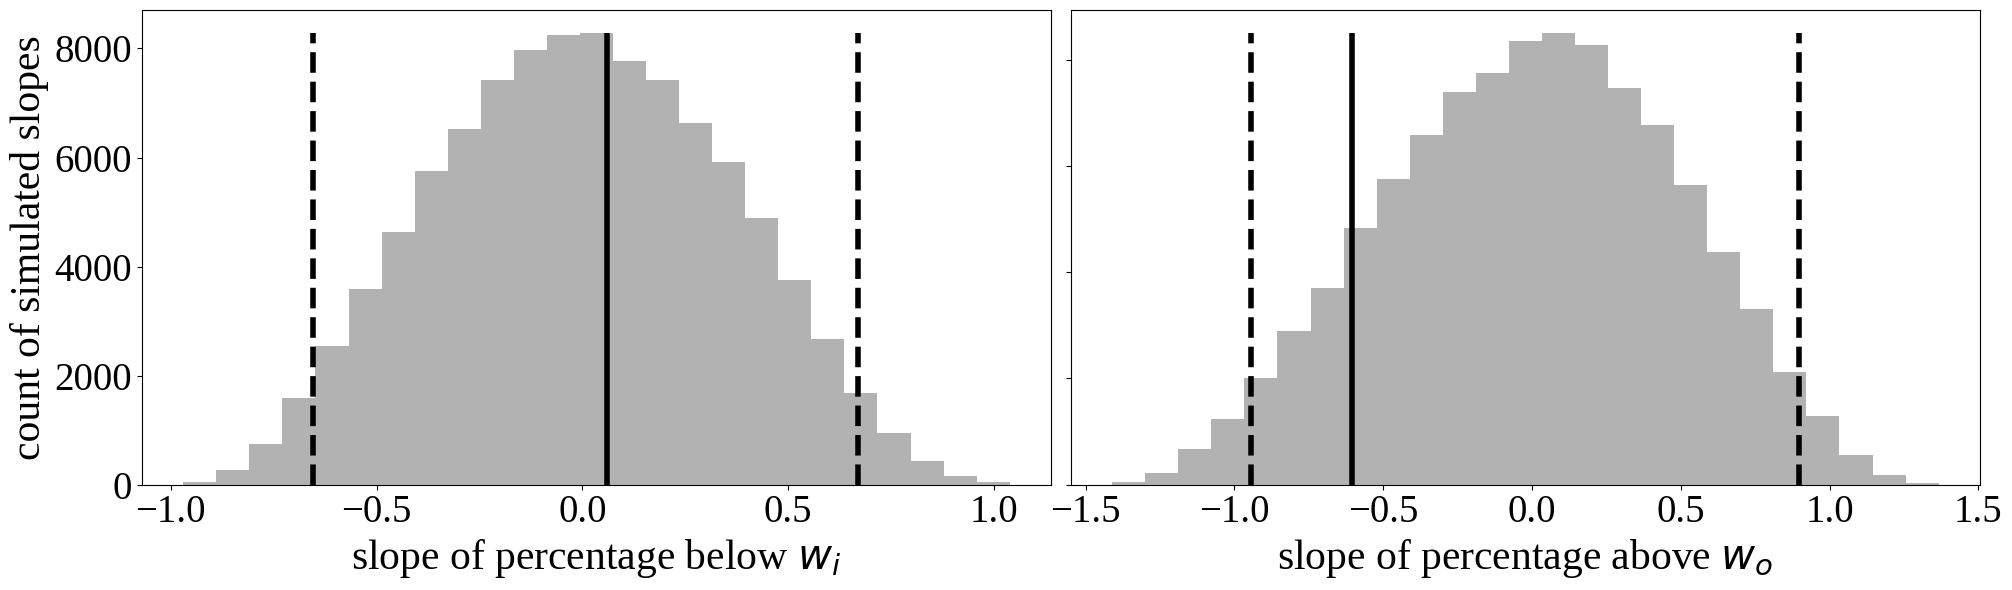

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(FIG_WIDTH, FIG_HEIGHT))

ax = axes[0]
ax.set_ylabel("count of simulated slopes", fontsize=LABEL_SIZE)
x_label = 'slope of percentage below $w_i$'
print_historgram_of_permutation_test(ax, list_of_models, "low", x_label)

ax = axes[1]
x_label = 'slope of percentage above $w_o$'
print_historgram_of_permutation_test(ax, list_of_models, "high", x_label)
ax.yaxis.set_ticklabels([])

fig.tight_layout()
legend_name = f'tails_histograms_europeland_126m_2005-2015'
fig.savefig(f'{legend_name}.pdf', bbox_inches="tight")

log odds: Intercept Slope St.Dev. R-squared  P-value
log odds & -1.667 & 0.036 & 0.394 & 0.090 & 0.9301 \\
: Intercept Slope St.Dev. R-squared  P-value
 & -1.355 & 0.059 & 0.371 & 0.282 & 0.8769 \\
: Intercept Slope St.Dev. R-squared  P-value
 & -1.042 & 0.085 & 0.346 & 0.660 & 0.8123 \\


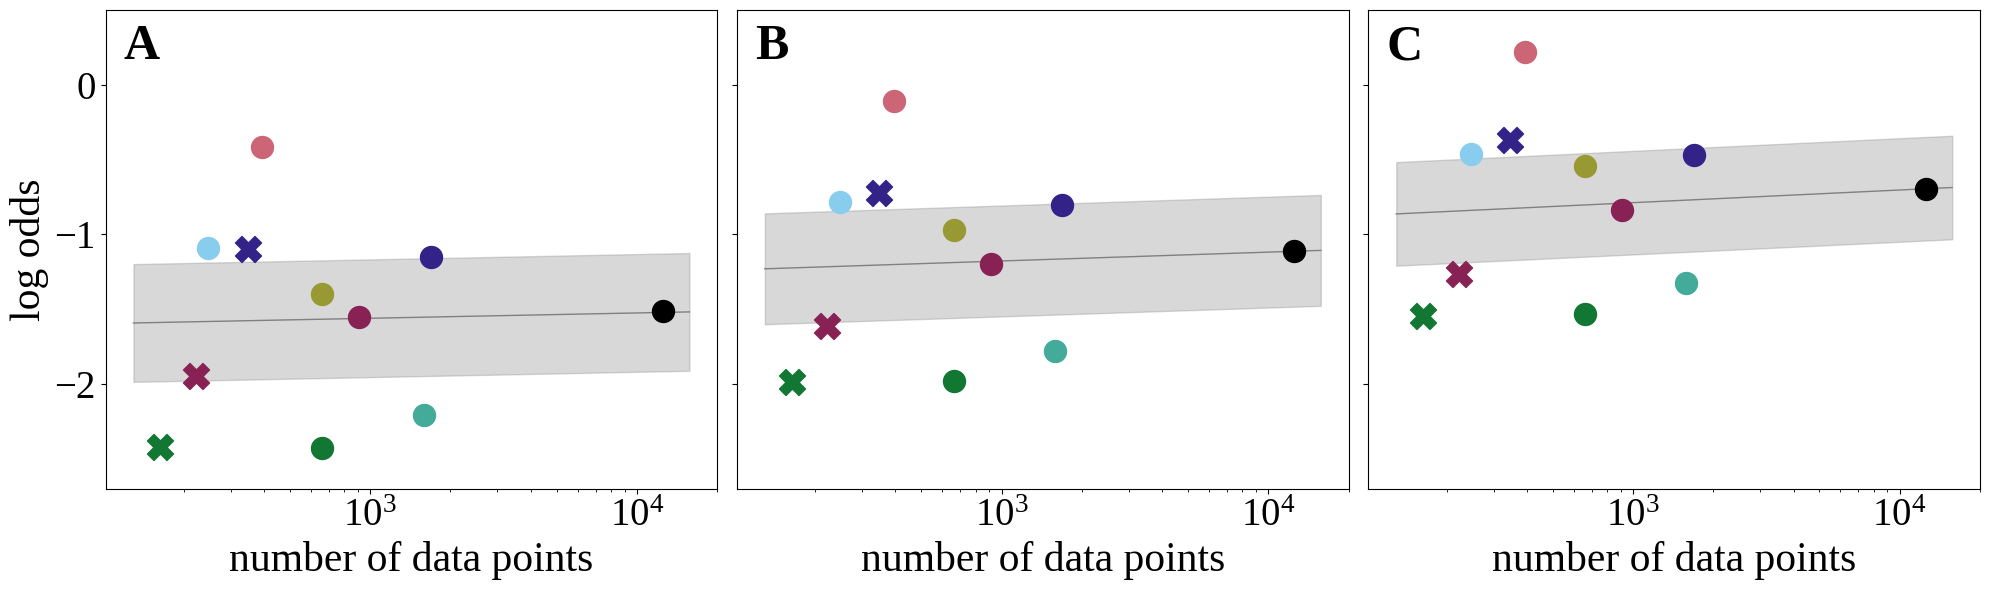

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(FIG_WIDTH, FIG_HEIGHT))
y_min = -2.7 #-25
y_max = 0.5 #90

ax = axes[0]
list_of_models = create_model_file_list(85) # cut-in=2.1
y_label = 'log odds'
#permu_results_low = get_permutation_test_results(list_of_models, "low")
plot_trend_with_spatial_resolution(ax, 'low', y_label, 'A') #permu_results_low
ax.set_ylim(y_min, y_max)

ax = axes[1]
list_of_models = create_model_file_list(126) #cut-in=2.6
#permu_results_low = get_permutation_test_results(list_of_models, "low")
plot_trend_with_spatial_resolution(ax, 'low', '', 'B') #permu_results_low
ax.yaxis.set_ticklabels([])
ax.set_ylim(y_min, y_max)

ax = axes[2]
list_of_models = create_model_file_list(140) # cut_in=3.1
#permu_results_low = get_permutation_test_results(list_of_models, "low")
plot_trend_with_spatial_resolution(ax, 'low', '', 'C') #permu_results_low
ax.yaxis.set_ticklabels([])
ax.set_ylim(y_min, y_max)

fig.tight_layout()
legend_name = f'low_tails_europeland_126m_2005-2015_with_regression'
fig.savefig(f'{legend_name}.pdf', bbox_inches="tight")

log odds: Intercept Slope St.Dev. R-squared  P-value
log odds & -7.684 & -0.640 & 0.503 & 15.220 & 0.2356 \\
: Intercept Slope St.Dev. R-squared  P-value
 & -6.050 & -0.604 & 0.470 & 15.512 & 0.2307 \\
: Intercept Slope St.Dev. R-squared  P-value
 & -6.709 & -0.618 & 0.475 & 15.809 & 0.2259 \\


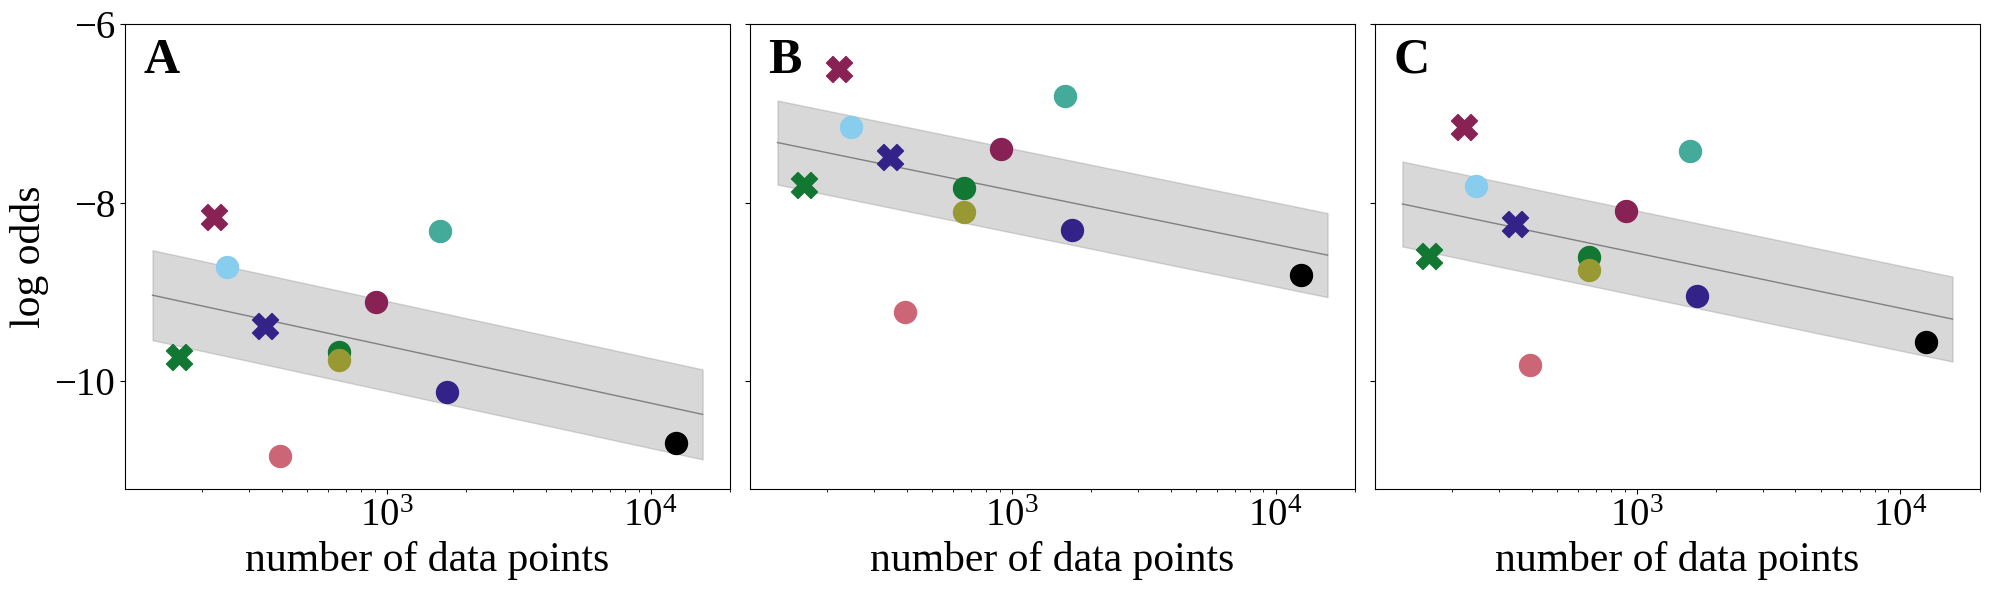

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(FIG_WIDTH, FIG_HEIGHT))
y_lim_min = -11.2 #-0.05
y_lim_max = -6 #0.365

ax = axes[0]
list_of_models = create_model_file_list(85) # cut-off=25.1
#permu_results_high = get_permutation_test_results(list_of_models, "high")
y_label = 'log odds'
plot_trend_with_spatial_resolution(ax, 'high', y_label, 'A') #permu_results_high
ax.set_ylim(y_lim_min, y_lim_max)

ax = axes[1]
list_of_models = create_model_file_list(126) #22.6
#permu_results_high = get_permutation_test_results(list_of_models, "high")
plot_trend_with_spatial_resolution(ax, 'high', '', 'B') #permu_results_high
ax.set_ylim(y_lim_min, y_lim_max)
ax.yaxis.set_ticklabels([])

ax = axes[2]
list_of_models = create_model_file_list(140) # cut-off: 24.6
#permu_results_high = get_permutation_test_results(list_of_models, "high")
plot_trend_with_spatial_resolution(ax, 'high', '', 'C') #permu_results_high
ax.yaxis.set_ticklabels([])
ax.set_ylim(y_lim_min, y_lim_max)

fig.tight_layout()
legend_name = f'high_tails_europeland_126m_2005-2015_with_regression'
fig.savefig(f'{legend_name}.pdf', bbox_inches="tight")